## 組合せ最適化問題
量子コンピュータで最適化問題を解くには、イジングモデルといわれる物理モデルを利用する。

## QUBO定式化
QUBOは問題の答えが小さいほうが正解になるように設定された式です。式の形は、

$$
QUBO = -\sum_i h_i q_i -\sum_{i,j}J_{ij}q_iq_j
$$

となっている。iとjは点を表し、hはバイアス（局所磁場）、Jは相互作用と呼ばれます。この式ではqは量子ビットを表し0か1を取ります（イジングの場合は+1か-1）。
私たちはhとJを問題として設定し、qの値を求めます。

## 問題設定の仕方
問題の設定の仕方は、グラフ問題というものに問題を落とすことで計算できますが、いくつか問題を解くことでコツをつかめます。

主に問題のコスト関数は二種類の式を考える必要があります。

１．小さくしたいコスト関数  
２．満たすべき条件（制約条件）

この二つを別々に設計し、つなげることで実装できます。片方しかない式もあります。

In [1]:
!pip install --quiet matplotlib

## クラスター分割問題
与えられたデータを$n$個のデータに分割する問題. 

### イジング式
データを2個のクラスターに分割する場合を考える. 
スピン変数を$q_i=+1$のときクラスター1に属しているとして, $q_i=-1$のときにクラスター2に属しているとする. 

$i$番目と$j$番目のデータの距離を$d_{i,j}$とするときに, 距離を最小化するようにイジング式を作ります. 

$$
H = \sum^N_{i,j} d_{i,j} q_i q_j
$$

### 問題設定
下記のように10個のデータを考えます. 

[{'q_{0}': 0, 'q_{1}': 0, 'q_{2}': 0, 'q_{3}': 0, 'q_{4}': 1, 'q_{5}': 1, 'q_{6}': 0, 'q_{7}': 0, 'q_{8}': 1, 'q_{9}': 0}, -276.8182444664205, 53]


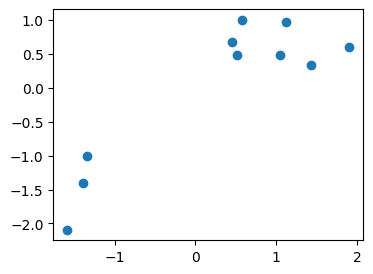

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tytan import symbols, Compile, sampler



x=np.array([0.456418,1.902223,0.512496,1.049233,-1.338122,-1.582395,1.433849,0.574857,-1.388644,1.120863])
y=np.array([0.681894,0.598139,0.493532,0.485759,-1.001241,-2.094026,0.346436,1.007253,-1.406806,0.97977])

plt.figure(figsize=(4,3))
plt.scatter(x, y)

#今回は10量子ビット
N = 10
#q = Array.create('q', shape=(N), vartype='SPIN')
q = symbols("q_{0:"+str(N)+"}")

def dist(i,j):
    z=np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
    return z
    
#式A
HA=0
for i in range(N):
    for j in range(N):
        HA += dist(i,j)*(2*q[i] - 1)*(2*q[j] - 1)

#式をつなげる
H=HA

Q, offset = Compile(H).get_qubo()

solver = sampler.SASampler()
result = solver.run(Q)
print(result[0])

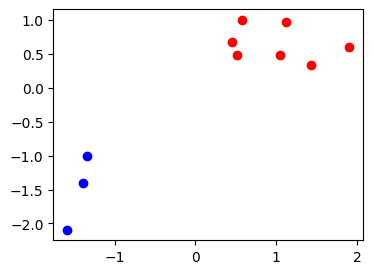

In [2]:
x=np.array([0.456418,1.902223,0.512496,1.049233,-1.338122,-1.582395,1.433849,0.574857,-1.388644,1.120863])
y=np.array([0.681894,0.598139,0.493532,0.485759,-1.001241,-2.094026,0.346436,1.007253,-1.406806,0.97977])
#c=np.array([0,0,0,0,1,1,0,0,1,0])
c=np.zeros(N)
for i in range(N):
    if result[0][0]["q_{"+str(i)+"}"] == 1:
        c[i] = 1

plt.figure(figsize=(4,3))
for i in range(N):
    if c[i]==0:
        plt.scatter(x[i], y[i],c="red")
    else:
        plt.scatter(x[i], y[i],c="blue")

## Nクラスター分割問題
データ数$n$、クラスタ数$k$として、$n*k$の量子ビット数が必要。
データ数に対してクラスタ数だけコピーを作る。

### QUBO式
2値クラスターでは, $+1$と$-1$のイジングモデルを用いたが, $N$クラスターでは$0,1$のQUBO関数を用いる. 
バイナリ変数$q_{i,l}$は$i$番目のデータが$l$番目のクラスターのとき$1$, それで無ければ$0$
コスト関数は, 各クラスター毎に距離を計算すればよい.   
異なるクラスター同士は考慮しなくてよい. 

$$
Cost = \sum_l^k\sum_{ij}^n d_{ij} q_{i,l} q_{j,l}\ \ \ \ (q_i \in \{0, 1\})
$$

制約として, データはただ$1$つのクラスターに属する条件
$$
Constraint = \sum_i^n(\sum_{l}^k q_{i,l} - 1)^2
$$

$0$番目のデータが4クラスターのどれに分類されるか調べるときに
$$
q_{0,0}+q_{0,1}+q_{0,2}+q_{0,3}
$$
のどれか1つが1になればよいので
$$
(q_{0,0}+q_{0,1}+q_{0,2}+q_{0,3}-1)^2
$$
を制約式とする. 

Cost = 3087.519864936692
Break = {}


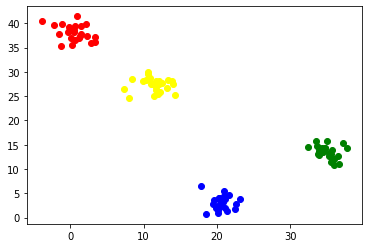

In [4]:
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(0)

n_node = 100
n_cluster = 4

#color = [np.random.randint(0,4) for _ in range(n_node)]

x=np.array([1.46810698,3.3613398,2.80133699,-1.46591682,1.42513263,-0.22703581,-0.15482828,0.61589775,0.21606536,2.18141026,1.14155659,0.18251252,0.66579485,0.50051149,2.24111861,-0.3077374,0.46960155,-1.28114361,-3.82948472,0.98042789,1.2966543,-1.11324753,3.40463194,-2.18154851,0.06863778,36.67956794,34.31311637,35.6380901,34.95804322,37.21398475,35.97017015,34.45349853,33.98183392,34.46955822,33.88887879,33.98746725,34.80082362,35.92970159,37.68675269,35.25650066,32.41149297,35.24098781,33.71152202,34.69036859,35.7326397,33.74250355,35.57174562,33.51364508,36.52682007,35.51238109,19.51161368,22.51692798,23.10066013,20.01751247,20.61631396,19.92842159,20.24874185,21.08346801,20.26655733,20.43011633,21.38960198,18.47797704,19.62480779,20.82116385,20.33058408,17.78496684,21.01505665,20.16266612,21.72135848,20.13878698,20.6212986,22.55977018,20.96478071,21.13413343,20.10850894,10.97159387,9.96397541,12.19964247,14.32121179,11.65830712,11.95738955,14.02376208,10.63452087,13.30075348,12.14712535,7.31498147,8.44452693,11.63022961,10.55277639,11.39540328,12.09689889,11.34210563,7.95721413,12.4492856,10.7196173,10.29151275,13.90498381,13.21601063,10.87266484,11.64154486])
y=np.array([37.71922422,37.18862555,36.01515895,37.83080162,39.36101891,39.22290486,38.34364692,36.46073183,38.7162882,39.93904734,36.90281265,35.59189662,39.48421426,38.16622192,37.42860288,38.17243876,38.51796896,35.39756185,40.48752666,41.44965729,37.29329711,39.89407323,36.24422683,39.5986838,36.95009392,11.12367068,14.38787613,11.64282076,15.7655373,15.28826086,10.83169663,13.56574092,12.89416416,13.90623956,13.7082235,14.22987594,14.36127943,12.12126569,14.40633826,12.61808786,14.46039807,13.31092416,14.64946296,14.40984547,13.9095835,13.00264126,11.51475979,15.80859112,12.63838961,13.08001736,2.84145481,1.84512589,3.80887379,1.98850101,3.04774584,2.04623088,4.01464994,3.86488622,2.68755187,3.59401007,1.36040774,0.76311361,3.65908755,3.25001024,3.95254716,6.57471716,4.41671923,1.63076666,4.67552443,1.02613888,2.30762309,2.89763759,5.57001408,1.88286777,1.76034219,27.54358061,28.14150143,25.77114421,25.14912361,26.2936312,25.35694167,27.56706517,29.57197334,28.37493631,28.07035669,26.45163544,28.60477852,26.97391112,29.89348328,24.99166511,27.50195441,27.5558494,24.67245887,27.72474568,28.58846208,28.36245221,28.15590387,26.75564322,28.73913909,28.13516919])

# 散布図を描画
#plt.scatter(x,y,c=color)

N=100
K=4
#100*4量子ビット
#q = Array.create('q', shape=N*K, vartype='BINARY')

#距離
def dist(i,j):
    z=np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
    return z
    
#式A
HA=0
for l in range(K):
 for i in range(N-1):
  for j in range(i+1,N):
     HA += dist(i,j)*q[l*N+i]*q[l*N+j]

HB=0
for i in range(N):
    tmp=0
    for l in range(K):
        tmp += q[i+N*l]
    HB += (tmp -1)**2

#式をつなげる
H = HA + 140*HB

#data = sampleset.record[0][0] # 結果を1次元配列に保存
data = sampleset.record[0][0]
np.set_printoptions(threshold=np.inf)
#print(data)

data=np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

cls = np.zeros(N)
for l in range(K):
    for i in range(N):
        if data[i+N*l]==1:
            cls[i]=l
#print(data)
#print(cls)
for i in range(N):
    if cls[i]==0:
        plt.scatter(x[i], y[i],c="red")
    elif cls[i]==1:
        plt.scatter(x[i], y[i],c="blue")
    elif cls[i]==2:
        plt.scatter(x[i], y[i],c="yellow")
    else:
        plt.scatter(x[i], y[i],c="green")
        

## vertex cover(頂点被覆問題)

あるグラフ$G=(V,E)$について、すべての頂点とつながる最小の頂点集合$V'$を求める問題  


## QUBO式

ノード$i$が集合$V'$含まれるときは$x_i=1$とする. 
QUBO最適化関数は、

$$
H = H _ A + H _ B
$$


ノード$v$とノード$u$が接続されているときに、2つのノード間のうちいずれか1つは1になる条件。(2つとも１になるのも含む)

$$
H_{A}=A\sum_{u,v \in E} (1-x_u) (1-x_v)
$$

$V'$の要素数を最小化する条件

$$
H_B = B \sum_{v \in V} x_v
$$


## 例題
$V={1,2,3,4,5}$  
$E={(0,1),(0,3),(1,2),(2,3),(3,4)}$  
のグラフ$G=(V,E)$
について、最小被覆頂点集合$V'$をもとめる。

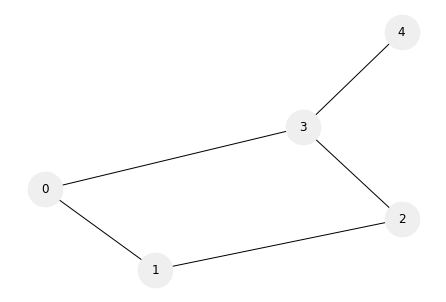

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

options = {'node_color': '#efefef','node_size': 1200,'with_labels':'True'}

N = 5

G = nx.Graph()
G.add_nodes_from(nx.path_graph(N))
G.add_edges_from([(0,1),(0,3),(1,2),(2,3),(3,4)])
nx.draw(G, **options)
#隣接行列
A = np.array(nx.to_numpy_matrix(G))

In [12]:
import numpy as np

#量子ビット
N=5 
#q = Array.create('q', shape=N, vartype='BINARY')

#集合V
V=np.array([0,1, 2, 3, 4])

#QUBO式
HA = 0
for v in range(N):
    for u in range(N):
        if A[u,v]==1:
            HA += (1-q[u])*(1-q[v])
    
HB = 0
for v in range(N):
    HB+=q[v]

#式をつなげる
H = 2*HA + HB

Sample = {'q[0]': 0, 'q[1]': 1, 'q[2]': 0, 'q[3]': 1, 'q[4]': 0}
Cost = 2.0
Break = {}


結果を確認すると、$S_0$と$S_1$を選択すると、全体集合の要素数をカバーできることが分かる。